In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

In [2]:
data = np.load('../marlim_comp.npz')  #  or 'marlim_orig.npz'
tres_h = data['res_h']
tres_v = data['res_v']

# We have to add an air layer
hz = np.r_[data['hz'], 20]

mesh_full = discretize.TensorMesh(
    [data['hx'], data['hy'], hz], x0=data['x0']
)

# Add air resistivity
res_h_full = 1e8*np.ones(mesh_full.vnC)
res_v_full = 1e8*np.ones(mesh_full.vnC)
res_h_full[:, :, :-1] = tres_h
res_v_full[:, :, :-1] = tres_v
del data, tres_h, tres_v

mesh_full

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

Text(0.5, 1.0, 'rho_v')

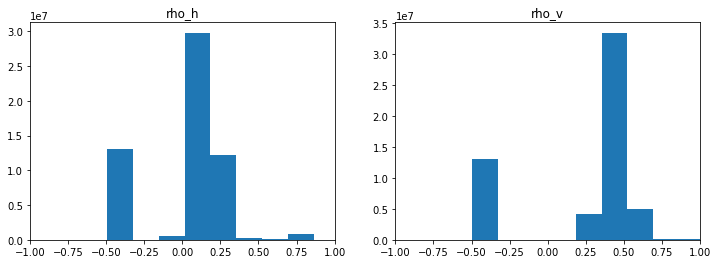

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

histh = ax[0].hist(np.log10(mkvc(res_h_full)), 50);
histv = ax[1].hist(np.log10(mkvc(res_v_full)), 50);

ax[0].set_xlim([-1, 1])
ax[1].set_xlim([-1, 1])

ax[0].set_title("rho_h")
ax[1].set_title("rho_v")

In [4]:
hist[1][0]

In [5]:
10**histh[1][1] - 10**histh[1][0]

0.15320244050825693

In [6]:
np.min(np.log10(res_h_full)), np.min(np.log10(res_v_full))

(-0.49485003138733225, -0.49485003138733225)

In [7]:
np.min(res_h_full), np.min(res_v_full)

(0.3199999928474426, 0.3199999928474426)

In [8]:
%%time
# compute the total gradient
dmdx_h = np.abs(mesh_full._cellGradxStencil * mkvc(res_h_full))
dmdy_h = np.abs(mesh_full._cellGradyStencil * mkvc(res_h_full))
dmdz_h = np.abs(mesh_full._cellGradzStencil * mkvc(res_h_full))

CPU times: user 25.9 s, sys: 10.7 s, total: 36.5 s
Wall time: 37 s


In [9]:
%%time
# compute the total gradient
dmdx_v = np.abs(mesh_full._cellGradxStencil * mkvc(res_v_full))
dmdy_v = np.abs(mesh_full._cellGradyStencil * mkvc(res_v_full))
dmdz_v = np.abs(mesh_full._cellGradzStencil * mkvc(res_v_full))

CPU times: user 26.2 s, sys: 10.8 s, total: 37 s
Wall time: 37.7 s


In [10]:
dmdx_h_nz = np.nonzero(dmdx_h)[0]
dmdy_h_nz = np.nonzero(dmdy_h)[0]
dmdz_h_nz = np.nonzero(dmdz_h)[0]

In [11]:
dmdx_v_nz = np.nonzero(dmdx_v)[0]
dmdy_v_nz = np.nonzero(dmdy_v)[0]
dmdz_v_nz = np.nonzero(dmdz_v)[0]

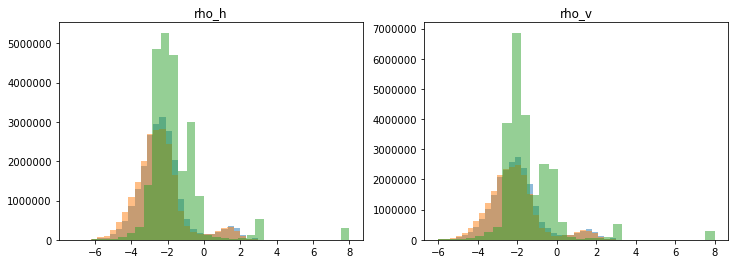

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for dim, h, v in zip(
    ["x", "y", "z"],
    [dmdx_h[dmdx_h_nz], dmdy_h[dmdy_h_nz], dmdz_h[dmdz_h_nz]],
    [dmdx_v[dmdx_v_nz], dmdy_v[dmdy_v_nz], dmdz_v[dmdz_v_nz]]
):

    ax[0].hist(np.log10(np.abs(mkvc(h))), 30, alpha=0.5);
    ax[1].hist(np.log10(np.abs(mkvc(v))), 30, alpha=0.5);

    ax[0].set_title("rho_h")
    ax[1].set_title("rho_v")

In [13]:
# average to cell centers and sum

dmdh = (
    mesh_full.aveFx2CC * dmdx_h + 
    mesh_full.aveFy2CC * dmdy_h + 
    mesh_full.aveFz2CC * dmdz_h
)

dmdv = (
    mesh_full.aveFx2CC * dmdx_v + 
    mesh_full.aveFy2CC * dmdy_v + 
    mesh_full.aveFz2CC * dmdz_v
)

In [14]:
dm = dmdh + dmdv

In [15]:
dm_nonzero = np.nonzero(dm)[0]

(array([8.0000000e+00, 1.8500000e+02, 3.2470000e+03, 3.0404000e+04,
        1.2459800e+05, 2.3574100e+05, 5.3933000e+05, 3.1231820e+06,
        5.4718920e+06, 1.3605903e+07, 7.4602590e+06, 7.8334060e+06,
        5.6419890e+06, 1.7179740e+06, 3.6301900e+05, 1.6212700e+05,
        2.9446200e+05, 6.2767800e+05, 4.8823100e+05, 1.2782330e+06,
        2.9898000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.7989000e+05]),
 array([-6.32162991, -5.84424225, -5.36685458, -4.88946692, -4.41207925,
        -3.93469159, -3.45730393, -2.97991626, -2.5025286 , -2.02514094,
        -1.54775327, -1.07036561, -0.59297795, -0.11559028,  0.36179738,
         0.83918504,  1.31657271,  1.79396037,  2.27134804,  2.7487357 ,
         3.22612336,  3.70351103,  4.18089869,  4.65828635,  5.13567402,
         5.61306168,  6.09044934,  6.56783701,  7.04522467,  7.52261234,
         8.        ]),
 <a list of 30 Patch ob

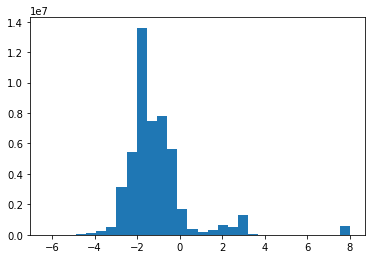

In [16]:
plt.hist(np.log10(dm[dm_nonzero]), 30)

In [17]:
threshold = 0.1
significant_dm = dm >= threshold

In [18]:
significant_dm.sum()

18134780

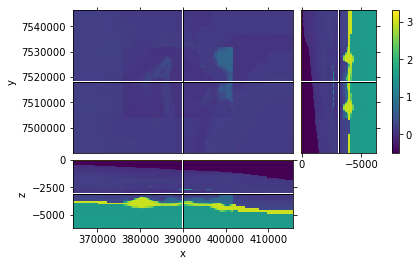

In [20]:
mesh_full.plot_3d_slicer(np.log10(res_h_full),  clim=[np.log10(0.32), np.log10(2000)])

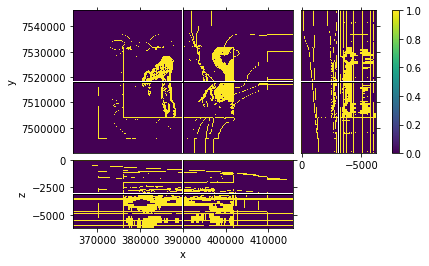

In [21]:
mesh_full.plot_3d_slicer(significant_dm)

## load survey info

In [22]:
ds = xr.load_dataset('../marlim_survey.nc', engine='h5netcdf')

In [23]:
# Use reciprocity: rec becomes src
src = [
    ds.rec_x, ds.rec_y, ds.rec_z,
    ds.rec_theta, ds.rec_dip
]

# Use reciprocity: src becomes rec
rec_x = ds.data_il.src_x[::2]
rec_y_il = ds.data_il.src_y
rec_z_il = ds.data_il.src_z

# Ensure same coordinates
print(np.allclose(rec_x, ds.data_bs.src_x[::2]))

rec_y_bs = ds.data_bs.src_y
rec_z_bs = ds.data_bs.src_z

rec_locs_il = discretize.utils.ndgrid([rec_x.data, rec_y_il, rec_z_il])
rec_locs_bs = discretize.utils.ndgrid([rec_x.data, rec_y_bs, rec_z_bs])

# Frequency
freqs = ds.freqs.values

True


In [24]:
print(rec_x.max() - rec_x.min())
print(rec_y_il.max() - rec_y_il.min())
print(rec_y_bs.max() - rec_y_bs.min())
print(rec_z_il.max() - rec_z_il.min())
print(rec_z_bs.max() - rec_z_bs.min())
# print(rec_z.max() - rec_z.min())

<xarray.DataArray 'src_x' ()>
array(21800., dtype=float32)
0.0
0.0
432.17328
429.44952


379375.0

In [60]:
# only refine in the core region where we are collecting data 

extra = 800. 

refine_points_core = significant_dm & (
    (mesh_full.gridCC[:, 0] > rec_x.data.min() - extra) &
    (mesh_full.gridCC[:, 0] < rec_x.data.max() + extra) & 
    (mesh_full.gridCC[:, 1] > rec_x.data.min()) &
    (mesh_full.gridCC[:, 1] > rec_x.data.max())
)

refine_points = mesh_full.gridCC[refine_points_core, :]

In [61]:
tmp = refine_points_core.nonzero()

In [62]:
tmp[0].shape

(10241564,)

In [63]:
significant_dm.nonzero()[0].shape

(18134780,)

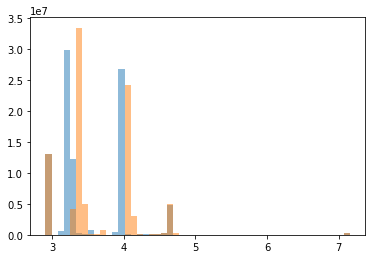

In [64]:
fig, ax = plt.subplots(1,1)
ax.hist(np.log10(503/np.sqrt(freqs[0]/mkvc(res_h_full))), 50, alpha=0.5);
ax.hist(np.log10(503/np.sqrt(freqs[0]/mkvc(res_v_full))), 50, alpha=0.5);

## design a mesh

In [78]:
# use the same discretization and domain extent in each dimension
dx, dy, dz = 100, 100, 40 

domain_x = float(rec_x.max() - rec_x.min())
domain_y = domain_x / 2
domain_z = refine_points[:, 2].max() - refine_points[:, 2].min()

ncore_x = domain_x/dx
ncore_y = domain_y/dy
ncore_z = domain_z/dz

print(ncore_x, ncore_y, ncore_z, ncore_x*ncore_y*ncore_z)

npad_x = 9
npad_y = 9
npad_z = 9

ncx = 2**int(np.ceil(np.log(ncore_x + npad_x*2)/np.log(2.)))
ncy = 2**int(np.ceil(np.log(ncore_y + npad_y*2)/np.log(2.)))
ncz = 2**int(np.ceil(np.log(ncore_z + npad_z*2)/np.log(2.)))

print(ncx, ncy, ncz, ncx*ncy*ncz)

pf = 1.4


218.0 109.0 155.0 3683110.0
256 128 256 8388608


In [79]:
mesh_full.x0

array([ 3.643250e+05,  7.490049e+06, -6.200000e+03])

In [80]:
mesh_full_center = np.r_[
    (mesh_full.gridCC[:, 0].min() + mesh_full.gridCC[:, 0].max())/2,
    (mesh_full.gridCC[:, 1].min() + mesh_full.gridCC[:, 1].max())/2,
    (mesh_full.gridCC[:, 2].min() + mesh_full.gridCC[:, 2].max())/2
]

In [81]:
mesh_full_center

array([ 3.900750e+05,  7.518199e+06, -3.090000e+03])

In [82]:
# define the base mesh
mesh = discretize.TreeMesh(
    [
        [(dx, npad_x, -pf), (dx, ncx-npad_x*2), (dx, npad_x, pf)], 
        [(dy, npad_y, -pf), (dy, ncy-npad_y*2), (dy, npad_y, pf)], 
        [(dz, npad_z, -pf), (dz, ncz-npad_z*2), (dz, npad_z, pf)]
    ]
)

mesh.x0 = np.r_[
    -np.sum(mesh.h[0])/2., -np.sum(mesh.h[1])/2., -np.sum(mesh.h[2][:ncz-npad_z])
] + mesh_full_center


# refine around the sources and receivers
xr, yr, zr = np.meshgrid(src[0:2], src[2] + dy/2*np.r_[-1, 1], src[4] + dz/2*np.r_[-1, 1]) 
src_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]

mesh = discretize.utils.refine_tree_xyz(
    mesh, src_refine, 
    octree_levels=[2, 2, 1], method="box", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_il, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rec_locs_bs, 
    octree_levels=[2, 2, 1], method="radial", finalize=False
)

# refine around interesting surfaces
# this is currently not the best way to do this... 
n_batches = 100
n_values = np.ceil(refine_points.shape[0]/n_batches)
for i in range(n_batches+1): 
    inds = np.r_[int(i*n_values), int(np.min([(i+1)*n_values, refine_points.shape[0]]))]
    print(i, inds)
    mesh = discretize.utils.refine_tree_xyz(
        mesh, refine_points[slice(inds[0], inds[1]), :], 
        octree_levels=[1, 1], method="radial", finalize=False
    )

mesh.finalize()

# return mesh

0 [     0 102416]
1 [102416 204832]
2 [204832 307248]
3 [307248 409664]
4 [409664 512080]
5 [512080 614496]
6 [614496 716912]
7 [716912 819328]
8 [819328 921744]
9 [ 921744 1024160]
10 [1024160 1126576]
11 [1126576 1228992]
12 [1228992 1331408]
13 [1331408 1433824]
14 [1433824 1536240]
15 [1536240 1638656]
16 [1638656 1741072]
17 [1741072 1843488]
18 [1843488 1945904]
19 [1945904 2048320]
20 [2048320 2150736]
21 [2150736 2253152]
22 [2253152 2355568]
23 [2355568 2457984]
24 [2457984 2560400]
25 [2560400 2662816]
26 [2662816 2765232]
27 [2765232 2867648]
28 [2867648 2970064]
29 [2970064 3072480]
30 [3072480 3174896]
31 [3174896 3277312]
32 [3277312 3379728]
33 [3379728 3482144]
34 [3482144 3584560]
35 [3584560 3686976]
36 [3686976 3789392]
37 [3789392 3891808]
38 [3891808 3994224]
39 [3994224 4096640]
40 [4096640 4199056]
41 [4199056 4301472]
42 [4301472 4403888]
43 [4403888 4506304]
44 [4506304 4608720]
45 [4608720 4711136]
46 [4711136 4813552]
47 [4813552 4915968]
48 [4915968 5018384]

In [83]:
mesh

OcTreeMesh: 29.16% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  2   :        8             ---------------------------   --------------------
  3   :       64          x: 371293.6336256,408856.36637440004     100.0   , 12381.366374400037
  4   :       130         y: 7505817.6336256,7530580.3663743995     100.0   , 12381.366374400444
  5   :      1042         z: -15362.546549759998,-337.45345024000017      40.0   , 4952.546549759998
  6   :      6439      
  7   :      39731     
  8   :     2398376    
-----------------------
Total :     2445790

In [84]:
mesh.nC

2445790